# Customer Segmentation Unsupervised Learning Approach

I will be working with training data.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vetrirah/customer")

print("Path to dataset files:", path)

100%|██████████| 105k/105k [00:00<00:00, 297kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vetrirah/customer/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
df_train = pd.read_csv(path + '/Train.csv')

In [ ]:
from sklearn.model_selection import train_test_split

cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
num_cols = ['Age', 'Work_Experience', 'Family_Size']
drop_cols = ['ID']
target_col = 'Segmentation'

X = df_train.drop(columns=[target_col])
y = df_train[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num_pipe', num_pipe, num_cols),
        ('cat_pipe', cat_pipe, cat_cols)
    ]
)


X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

In [ ]:
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X_train_transformed)

cumsum = np.cumsum(pca.explained_variance_ratio_)

print(f'old shape: {X_train_transformed.shape}')
print(f'new shape: {X2D.shape}')
print(f'n_components: {pca.n_components}')
print(f'explained variance ratio: {pca.explained_variance_ratio_}')
print(f'explained variance cumulative ratio: {cumsum}')
print(f'unexplained variance ratio: {1-pca.explained_variance_ratio_.sum()}')


old shape: (6454, 28)
new shape: (6454, 2)
n_components: 2
explained variance ratio: [0.25372468 0.17401697]
explained variance cumulative ratio: [0.25372468 0.42774165]
unexplained variance ratio: 0.5722583520900505


In [ ]:
pca_pipe = Pipeline(
    [
        ('pca', PCA(n_components=8, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
)

pca_pipe.fit(X_train_transformed, y_train)
pca_pipe.score(X_test_transformed, y_test)

0.4919454770755886

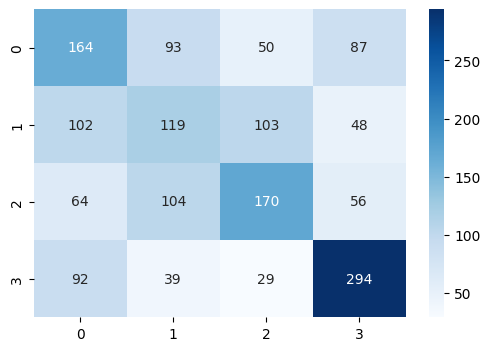

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = cross_val_predict(pca_pipe, X_test_transformed, y_test, cv=3)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=True)
plt.show()



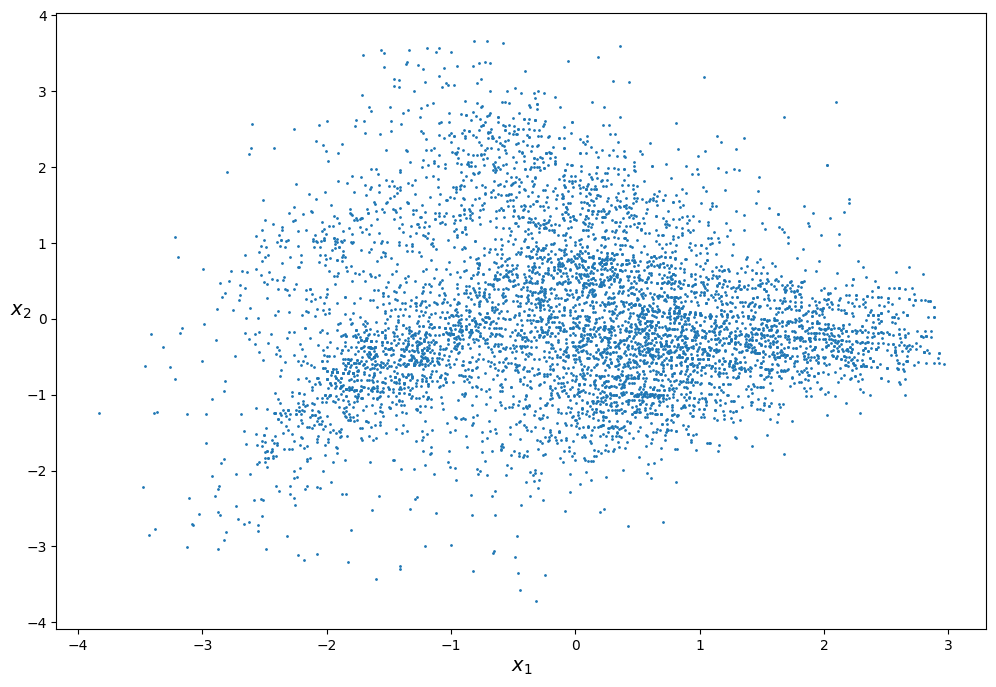

In [ ]:
def plot_clusters(X, y=None):
  plt.figure(figsize=(12, 8))
  plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
  plt.xlabel('$x_1$', fontsize=14)
  plt.ylabel('$x_2$', fontsize=14, rotation=0)
  plt.show()

plot_clusters(X2D)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
y_pred = kmeans.fit_predict(X2D)
y_pred[:5]

array([2, 1, 3, 0, 2], dtype=int32)

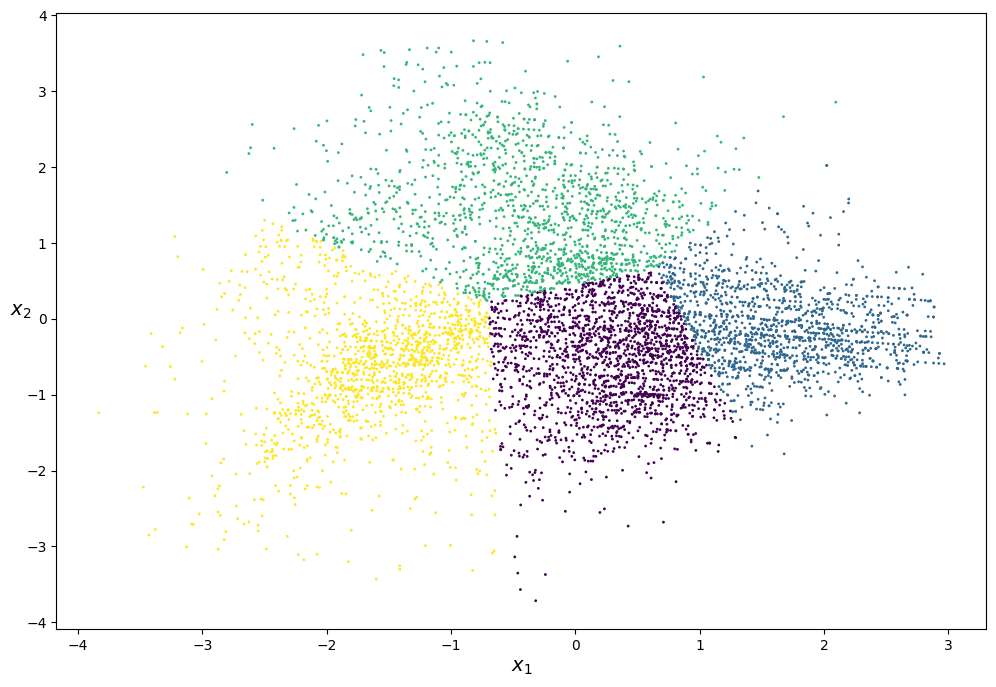

In [ ]:
plot_clusters(X2D, y_pred)

In [ ]:
kmeans.cluster_centers_

array([[ 0.27417134, -0.55465463],
       [ 1.65946689, -0.1095291 ],
       [-0.37509902,  1.42354905],
       [-1.62324869, -0.63430423]])

In [ ]:
y_pred is kmeans.labels_

True

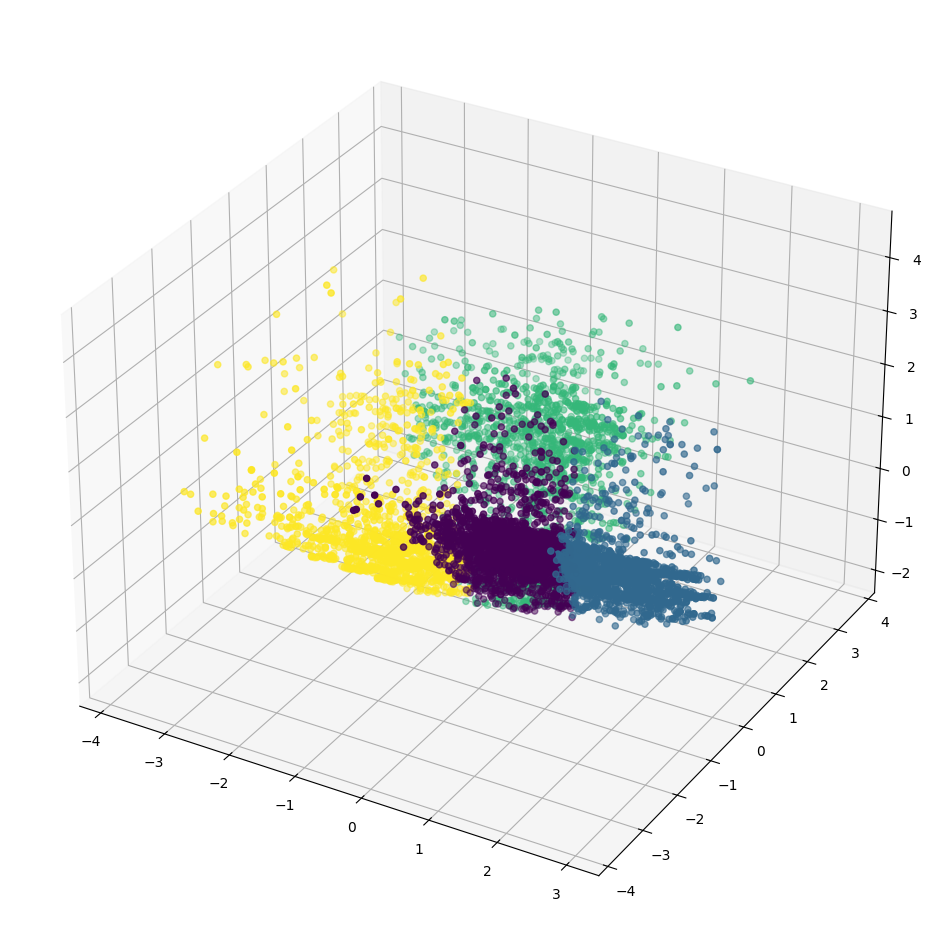

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

pca_3 = PCA(n_components=3)
X3D = pca_3.fit_transform(X_train_transformed)

ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=y_pred);

In [ ]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X_train_transformed)

In [ ]:
print(f'unique labels: {np.unique(kmeans.labels_)}')
print(f'{kmeans.cluster_centers_.shape[0]} centroids')

unique labels: [0 1 2 3]
4 centroids


best silhouette score: 0.19249473596824507


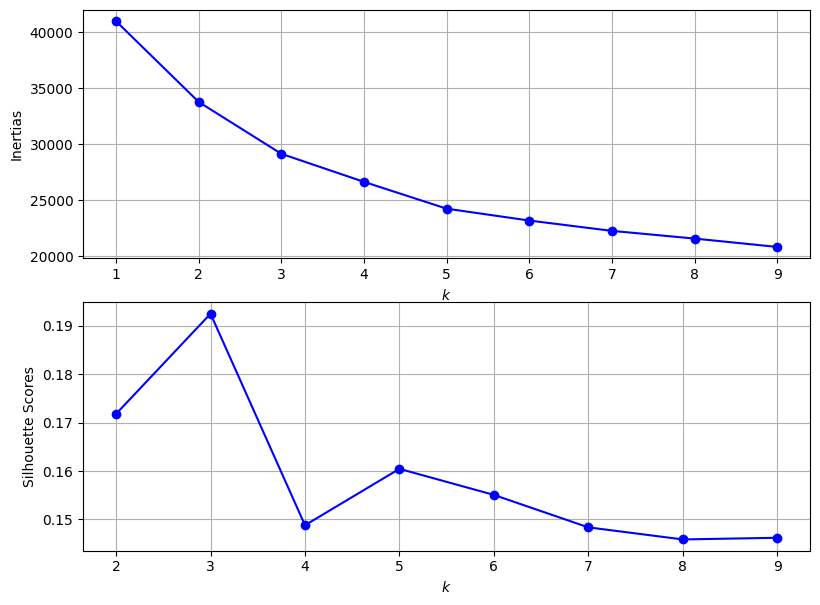

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train_transformed) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X_train_transformed, model.labels_) for model in kmeans_per_k[1:]]


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig.tight_layout()
ax[0].plot(range(1, 10), inertias, 'bo-')
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('Inertias')
ax[0].grid()

ax[1].plot(range(2, 10), silhouette_scores, 'bo-')
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('Silhouette Scores')
ax[1].grid()

print(f'best silhouette score: {np.max(silhouette_scores)}')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
y_train[:5]

,Segmentation
917,A
3398,B
2045,B
8060,A
4604,A


In [ ]:
y_train.values.reshape(-1, 1)

array([['A'],
       ['B'],
       ['B'],
       ...,
       ['D'],
       ['D'],
       ['A']], dtype=object)

In [ ]:
# ordinally encoding y_train

from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[['A', 'B', 'C', 'D']])
y_train_oe = oe.fit_transform(y_train.values.reshape(-1, 1))

np.unique(y_train_oe)

array([0., 1., 2., 3.])

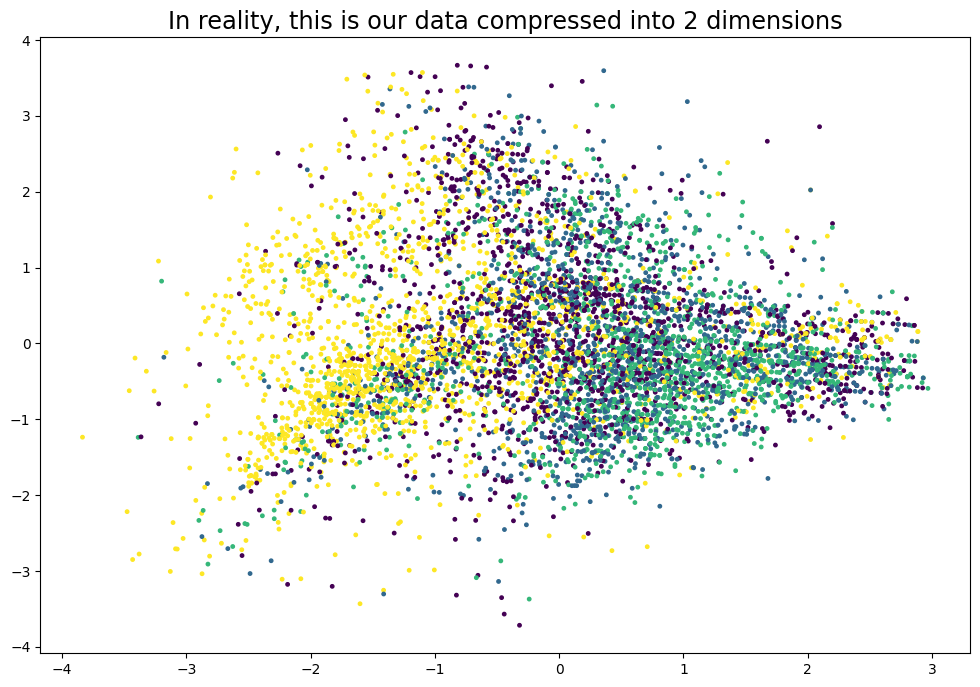

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(X2D[:, 0], X2D[:, 1], c=y_train_oe, s=6);
plt.title('In reality, this is our data compressed into 2 dimensions', fontsize='xx-large');

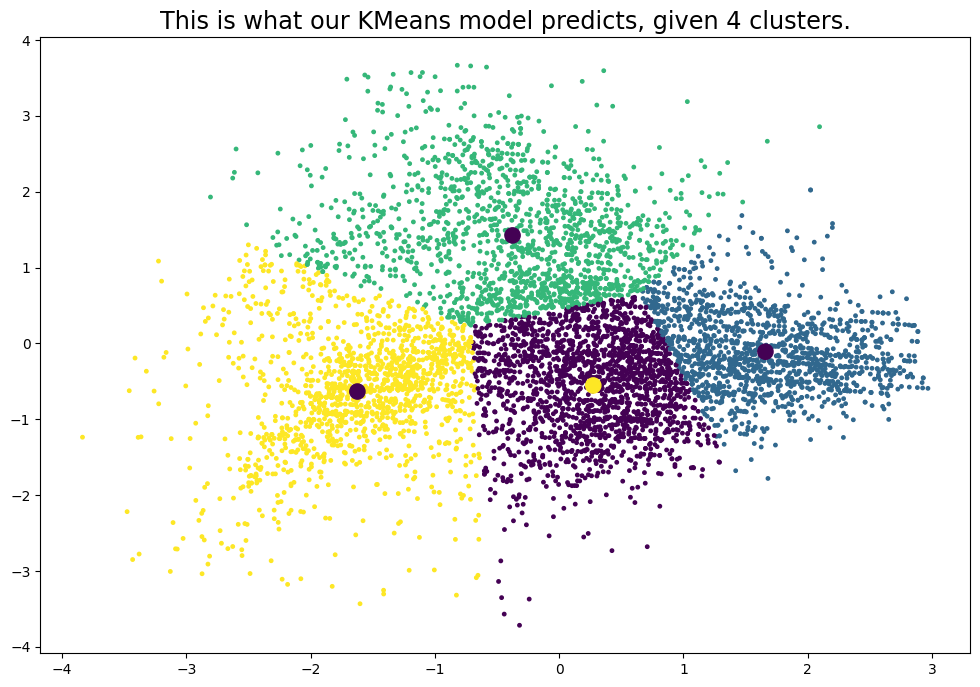

In [ ]:
X2D = PCA(n_components=2).fit_transform(X_train_transformed)

kmeans = KMeans(n_clusters=4, n_init=15, random_state=42)
y_pred = kmeans.fit_predict(X2D)

plt.figure(figsize=(12, 8))
plt.scatter(X2D[:, 0], X2D[:, 1], c=y_pred, s=6);
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=120, c=[0.75, 0.15, 0.15, 0.15]);
plt.title('This is what our KMeans model predicts, given 4 clusters.', fontsize='xx-large');


Text(0.5, 0.92, 'This is our data compressed into 3 dimensions! Dumbledore said calmly.')

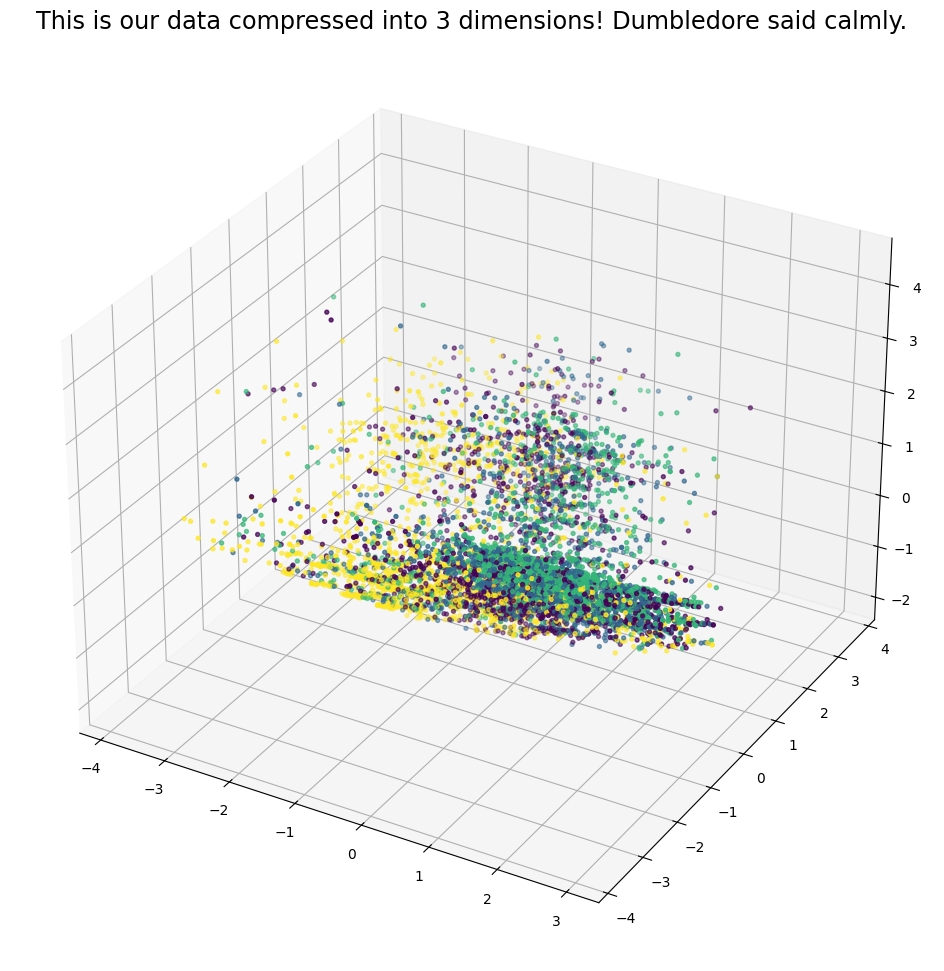

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=15, random_state=42)
y_pred = kmeans.fit_predict(X3D)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')


ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=y_train_oe, s=8);
plt.title('This is our data compressed into 3 dimensions! Dumbledore said calmly.', fontsize='xx-large')

Text(0.5, 0.92, 'These are predictions of KMeans model given 4 clusters')

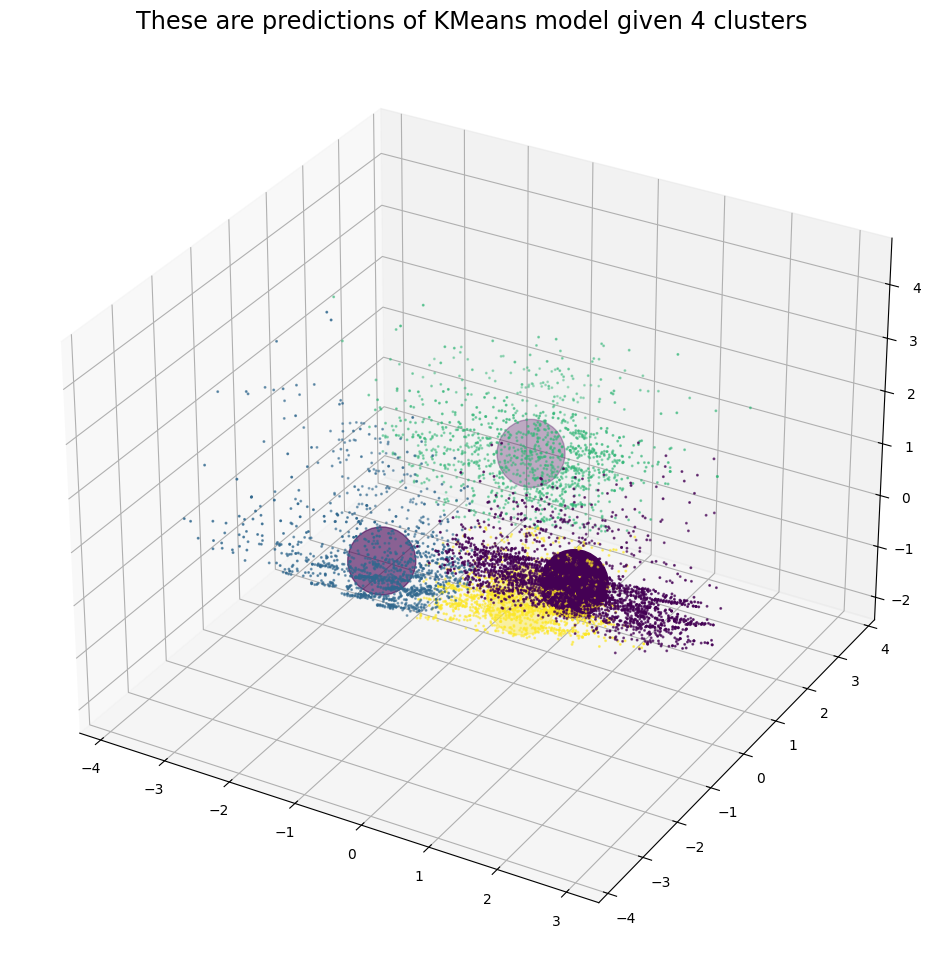

In [ ]:
X3D = PCA(n_components=3).fit_transform(X_train_transformed)

kmeans = KMeans(n_clusters=4, n_init=15, random_state=42)
y_pred = kmeans.fit_predict(X3D)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')


ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=y_pred, s=1.2);
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=2400, c=[0.1,0.1,0.1,0.8]);

plt.title('These are predictions of KMeans model given 4 clusters', fontsize='xx-large')

In [ ]:
kmeans.cluster_centers_

array([[ 1.14563266, -0.46376696,  0.20583954],
       [-1.55592741, -0.85862836, -0.13795081],
       [-0.54969149,  1.54210064,  0.89903932],
       [-0.04035465,  0.32369095, -1.04848904]])

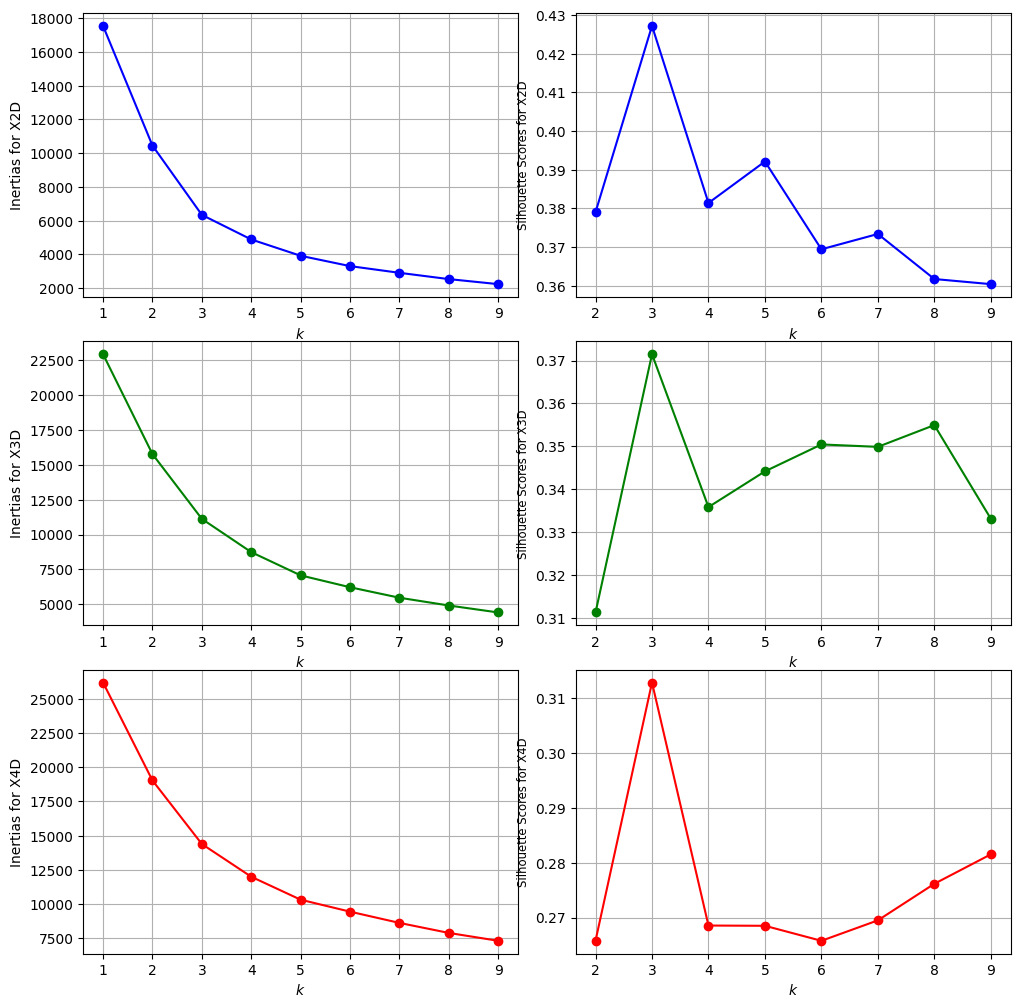

In [ ]:
X2D = PCA(n_components=2).fit_transform(X_train_transformed)
X3D = PCA(n_components=3).fit_transform(X_train_transformed)
X4D = PCA(n_components=4).fit_transform(X_train_transformed)

kmeans_per_k_x2d = [KMeans(n_clusters=k, n_init=15, random_state=42).fit(X2D) for k in range(1, 10)]
inertias_x2d = [model.inertia_ for model in kmeans_per_k_x2d]
silhouette_scores_x2d = [silhouette_score(X2D, model.labels_) for model in kmeans_per_k_x2d[1:]]

kmeans_per_k_x3d = [KMeans(n_clusters=k, n_init=15, random_state=42).fit(X3D) for k in range(1, 10)]
inertias_x3d = [model.inertia_ for model in kmeans_per_k_x3d]
silhouette_scores_x3d = [silhouette_score(X3D, model.labels_) for model in kmeans_per_k_x3d[1:]]

kmeans_per_k_x4d = [KMeans(n_clusters=k, n_init=15, random_state=42).fit(X4D) for k in range(1, 10)]
inertias_x4d = [model.inertia_ for model in kmeans_per_k_x4d]
silhouette_scores_x4d = [silhouette_score(X4D, model.labels_) for model in kmeans_per_k_x4d[1:]]


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.tight_layout()


ax[0, 0].plot(range(1, 10), inertias_x2d, 'bo-')
ax[0, 0].set_xlabel('$k$')
ax[0, 0].set_ylabel('Inertias for X2D')
ax[0, 0].grid()


ax[0, 1].plot(range(2, 10), silhouette_scores_x2d, 'bo-')
ax[0, 1].set_xlabel('$k$')
ax[0, 1].set_ylabel('Silhouette Scores for X2D', fontsize='small')
ax[0, 1].grid()


ax[1, 0].plot(range(1, 10), inertias_x3d, 'go-')
ax[1, 0].set_xlabel('$k$')
ax[1, 0].set_ylabel('Inertias for X3D')
ax[1, 0].grid()


ax[1, 1].plot(range(2, 10), silhouette_scores_x3d, 'go-')
ax[1, 1].set_xlabel('$k$')
ax[1, 1].set_ylabel('Silhouette Scores for X3D', fontsize='small')
ax[1, 1].grid()


ax[2, 0].plot(range(1, 10), inertias_x4d, 'ro-')
ax[2, 0].set_xlabel('$k$')
ax[2, 0].set_ylabel('Inertias for X4D')
ax[2, 0].grid()


ax[2, 1].plot(range(2, 10), silhouette_scores_x4d, 'ro-')
ax[2, 1].set_xlabel('$k$')
ax[2, 1].set_ylabel('Silhouette Scores for X4D', fontsize='small')
ax[2, 1].grid()